In [13]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split


In [14]:
# Paths to predictions
tinybert_path = "/Users/tvishakhanna/MBFT_LITE_FL/fl_tinybert/fl_tinybert/results"
xgb_path = "/Users/tvishakhanna/MBFT_LITE_FL/results/xgboost"

clients = ["client_1", "client_2", "client_3", "client_4"]

meta_results_dir = "../results/meta_fusion"
os.makedirs(meta_results_dir, exist_ok=True)


In [15]:
from sklearn.model_selection import KFold

for client in clients:
    print(f"\n🔍 Training Meta-Fusion Classifier for {client}...")

    # Load prediction scores
    tinybert_file = os.path.join(tinybert_path, client, "predictions.csv")
    xgb_file = os.path.join(xgb_path, f"{client}_xgb_predictions.csv")

    df_tiny = pd.read_csv(tinybert_file)
    df_xgb = pd.read_csv(xgb_file)

    # Meta classifier features and labels
    X = np.vstack([
        df_tiny["Probability"].values,
        df_xgb["Probability"].values
    ]).T
    y = df_tiny["Actual"].values

    # 5-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accs, aucs = [], []

    print(f"\n🔁 Performing 5-Fold Cross-Validation on {client}...")

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        meta_model = LogisticRegression()
        meta_model.fit(X_train, y_train)

        y_pred = meta_model.predict(X_test)
        y_proba = meta_model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        accs.append(acc)
        aucs.append(auc)

        print(f"Fold {fold}: ACC={acc:.4f}, AUC={auc:.4f}")

    # Final results across folds
    avg_acc = np.mean(accs)
    avg_auc = np.mean(aucs)
    print(f"\n✅ Average Accuracy: {avg_acc:.4f}")
    print(f"✅ Average AUC: {avg_auc:.4f}")

    # Final evaluation from last fold only (for confusion matrix and ROC plot)
    print("\nClassification Report (last fold):")
    print(classification_report(y_test, y_pred, digits=4))

    # Save confusion matrix plot (from last fold)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Phish"], yticklabels=["Legit", "Phish"])
    plt.title(f"{client} - Meta Fusion Conf Matrix (Last Fold)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_path = os.path.join(meta_results_dir, f"{client}_conf_matrix.png")
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.close()
    print(f"📊 Confusion matrix saved to {cm_path}")

    # Save ROC curve (from last fold)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{client} - ROC Curve (Meta-Fusion Last Fold)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    roc_path = os.path.join(meta_results_dir, f"{client}_roc_curve.png")
    plt.tight_layout()
    plt.savefig(roc_path)
    plt.close()
    print(f"📈 ROC curve saved to {roc_path}")



🔍 Training Meta-Fusion Classifier for client_1...

🔁 Performing 5-Fold Cross-Validation on client_1...
Fold 1: ACC=1.0000, AUC=1.0000
Fold 2: ACC=1.0000, AUC=1.0000
Fold 3: ACC=1.0000, AUC=1.0000
Fold 4: ACC=0.9950, AUC=0.9956
Fold 5: ACC=0.9950, AUC=0.9996

✅ Average Accuracy: 0.9980
✅ Average AUC: 0.9990

Classification Report (last fold):
              precision    recall  f1-score   support

           0     1.0000    0.9905    0.9952       105
           1     0.9896    1.0000    0.9948        95

    accuracy                         0.9950       200
   macro avg     0.9948    0.9952    0.9950       200
weighted avg     0.9951    0.9950    0.9950       200

📊 Confusion matrix saved to ../results/meta_fusion/client_1_conf_matrix.png
📈 ROC curve saved to ../results/meta_fusion/client_1_roc_curve.png

🔍 Training Meta-Fusion Classifier for client_2...

🔁 Performing 5-Fold Cross-Validation on client_2...
Fold 1: ACC=1.0000, AUC=1.0000
Fold 2: ACC=1.0000, AUC=1.0000
Fold 3: ACC=1.0000,


🧪 Now testing the fusion model on the UNSEEN dataset...

📊 Accuracy on Unseen Set: 0.9790
📈 AUC on Unseen Set: 0.9834

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.99      0.97      0.98       181

    accuracy                           0.98       334
   macro avg       0.98      0.98      0.98       334
weighted avg       0.98      0.98      0.98       334



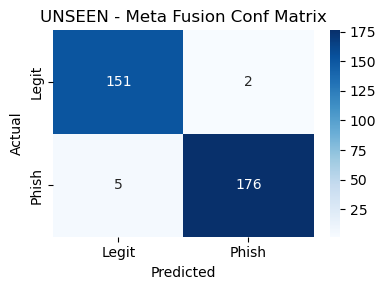

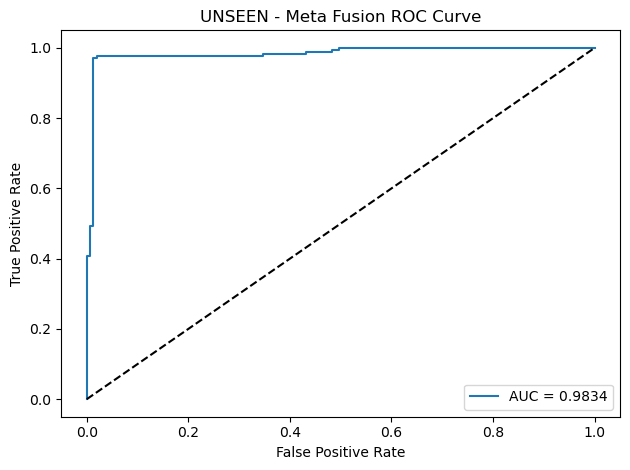

In [16]:
print("\n🧪 Now testing the fusion model on the UNSEEN dataset...")

# === Load unseen fusion probabilities ===
df_tiny_unseen = pd.read_csv("../data/unseen/tinybert_probabilities.csv")  # ['prob_class_0', 'prob_class_1', 'labels']
df_xgb_unseen = pd.read_csv("../data/unseen/xgboost_probabilities.csv")    # ['prob_class_0', 'prob_class_1', 'labels']

# Combine them into fusion input format
X_unseen = np.vstack([
    df_tiny_unseen["prob_class_1"].values,
    df_xgb_unseen["prob_class_1"].values
]).T
y_unseen = df_tiny_unseen["labels"].values

# === Re-train fusion model on ALL CLIENTS DATA (to simulate production model) ===
X_train_all, y_train_all = [], []

for client in clients:
    df_tiny = pd.read_csv(os.path.join(tinybert_path, client, "predictions.csv"))
    df_xgb = pd.read_csv(os.path.join(xgb_path, f"{client}_xgb_predictions.csv"))

    x_pair = np.vstack([
        df_tiny["Probability"].values,
        df_xgb["Probability"].values
    ]).T
    y = df_tiny["Actual"].values

    X_train_all.append(x_pair)
    y_train_all.append(y)

X_train_all = np.vstack(X_train_all)
y_train_all = np.hstack(y_train_all)

# Train fusion model on all client data
fusion_model = LogisticRegression()
fusion_model.fit(X_train_all, y_train_all)

# === Predict on UNSEEN set ===
y_pred = fusion_model.predict(X_unseen)
y_proba = fusion_model.predict_proba(X_unseen)[:, 1]

# === Metrics ===
acc = accuracy_score(y_unseen, y_pred)
auc = roc_auc_score(y_unseen, y_proba)

print(f"\n📊 Accuracy on Unseen Set: {acc:.4f}")
print(f"📈 AUC on Unseen Set: {auc:.4f}")
print("\n📋 Classification Report:\n", classification_report(y_unseen, y_pred))

# === Confusion Matrix ===
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_unseen, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Phish"], yticklabels=["Legit", "Phish"])
plt.title("UNSEEN - Meta Fusion Conf Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("../results/meta_fusion/unseen_conf_matrix.png")
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_unseen, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("UNSEEN - Meta Fusion ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("../results/meta_fusion/unseen_roc_curve.png")
plt.show()
